In [ ]:
# Install necessary packages
!pip install numpy pandas pyjanitor jax_unirep scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
# Install necessary tools in Google Colab
!apt-get install -y hmmer
!wget https://github.com/soedinglab/MMseqs2/releases/download/17-b804f/mmseqs-linux-gpu.tar.gz
!tar xvf mmseqs-linux-gpu.tar.gz
!chmod +x mmseqs

Ridge - MSE: 1.5844, Pearson Corr: 0.0518


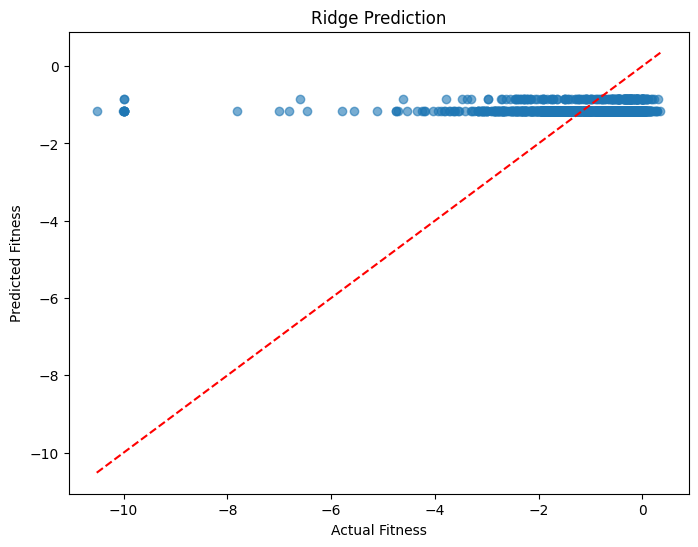

Lasso - MSE: 1.5836, Pearson Corr: 0.0518


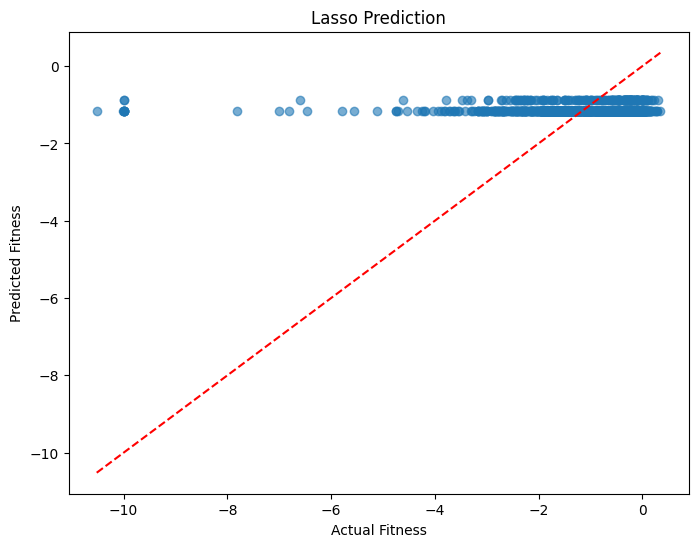

In [ ]:
import numpy as np
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import time
import subprocess
import os
import janitor
from functools import partial
from jax_unirep import get_reps
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)




# URLs for external tools
BLAST_URL = "https://blast.ncbi.nlm.nih.gov/Blast.cgi"

# Wild-type enzyme sequence
WT_SEQUENCE = "MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVERLTRSTTGVAQCPVGRLPYEG"


def run_blast_search(wt_sequence, identity_threshold=98.0, max_retries=20, sleep_time=10):
    """Run BLAST search and extract homologous sequences below a given identity threshold."""

    # **1. Submit BLAST Query**
    params = {
        "CMD": "Put",
        "PROGRAM": "blastp",
        "DATABASE": "nr",
        "QUERY": wt_sequence,
        "FORMAT_TYPE": "XML",
        "EXPECT": "10",  # Set e-value threshold (adjustable)
        "HITLIST_SIZE": "500"  # Increase number of results
    }

    response = requests.post(BLAST_URL, data=params)
    if response.status_code != 200:
        raise Exception(f"Error submitting sequence: {response.text}")

    response_text = response.text
    if "RID = " not in response_text:
        raise Exception("Error: No RID found in response.")

    rid = response_text.split("RID = ")[-1].split("\n")[0].strip()
    print(f" Submitted BLAST job with RID: {rid}")

    # **2. Wait for BLAST results**
    retries = 0
    while retries < max_retries:
        status_params = {"CMD": "Get", "FORMAT_OBJECT": "SearchInfo", "RID": rid}
        status_response = requests.get(BLAST_URL, params=status_params)

        if "Status=READY" in status_response.text:
            print(" BLAST search is complete.")
            break
        elif "Status=FAILED" in status_response.text:
            raise Exception(" BLAST job failed on NCBI server.")

        print(f"⏳ Waiting for BLAST results... (Attempt {retries + 1}/{max_retries})")
        time.sleep(sleep_time)
        retries += 1

    if retries == max_retries:
        raise Exception(" BLAST API timed out. Try increasing max_retries or sleep_time.")

    # **3. Retrieve BLAST results**
    result_params = {"CMD": "Get", "FORMAT_TYPE": "XML", "RID": rid}
    result_response = requests.get(BLAST_URL, params=result_params)
    if result_response.status_code != 200:
        raise Exception(f"Error retrieving results: {result_response.text}")

    # Print raw response for debugging
    print(result_response.text[:1000])  # Print first 1000 characters to check if XML is valid

    # **4. Parse BLAST results**
    root = ET.fromstring(result_response.text)
    homologous_sequences = []
    query_sequences = []
    identities = []

    for hit in root.findall(".//Hit"):
        hit_id = hit.find("Hit_id").text if hit.find("Hit_id") is not None else "Unknown"
        hit_def = hit.find("Hit_def").text if hit.find("Hit_def") is not None else "Unknown"

        for hsp in hit.findall(".//Hsp"):
            hsp_qseq_elem = hsp.find("Hsp_qseq")
            hsp_hseq_elem = hsp.find("Hsp_hseq")
            identity_elem = hsp.find("Hsp_identity")
            align_len_elem = hsp.find("Hsp_align-len")

            if hsp_qseq_elem is None or hsp_hseq_elem is None or identity_elem is None or align_len_elem is None:
                continue  # Skip if missing data

            qseq = hsp_qseq_elem.text.strip()
            hseq = hsp_hseq_elem.text.strip()
            identity = int(identity_elem.text)
            align_len = int(align_len_elem.text)
            identity_percentage = (identity / align_len) * 100

            if identity_percentage <= identity_threshold:
                homologous_sequences.append(hseq)  # Homologous sequences
                query_sequences.append(qseq)  # Query sequences
                identities.append(identity_percentage)
                print(f"✅ Found sequence from {hit_id}: {hit_def} (Identity: {identity_percentage:.2f}%)")

    print(f" Total homologous sequences collected: {len(homologous_sequences)}")
    print(f" Total query sequences collected: {len(query_sequences)}")

    return homologous_sequences, query_sequences, identities

# **Run BLAST API Search**
homologous_sequences, query_sequences, identities = run_blast_search(WT_SEQUENCE)

print(f" Retrieved {len(homologous_sequences)} homologous sequences.")
print(f" Retrieved {len(query_sequences)} query sequences.")
print(f" Average Sequence Identity: {sum(identities)/len(identities) if identities else 0:.2f}%")


def run_jackhmmer_search(wt_sequence, num_iter=3, evalue=1e-5):
    """Run Jackhmmer search using HMMER locally. Assumes HMMER is installed."""
    fasta_filename = "wt_sequence.fasta"
    with open(fasta_filename, "w") as f:
        f.write(f">WT_SEQUENCE\n{wt_sequence}\n")

    output_file = "jackhmmer_output.txt"
    cmd = f"jackhmmer --tblout {output_file} -N {num_iter} --cpu 4 -E {evalue} {fasta_filename} /usr/share/uniprot_sprot.fasta"

    subprocess.run(cmd, shell=True, check=True)

    sequences = []
    with open(output_file, "r") as f:
        for line in f:
            if not line.startswith("#"):
                columns = line.strip().split()
                if len(columns) > 1:
                    sequences.append(columns[0])  # Extract sequence ID

    print(f"Total sequences collected from Jackhmmer: {len(sequences)}")
    return sequences if sequences else [wt_sequence]


def run_mmseqs2_search(wt_sequence):
    """Run MMseqs2 locally in Google Colab."""

    # Save WT sequence to FASTA file
    fasta_filename = "wt_sequence.fasta"
    with open(fasta_filename, "w") as f:
        f.write(f">WT_SEQUENCE\n{wt_sequence}\n")

    db_name = "uniref50"
    output_file = "mmseqs_output.m8"

    # Create database, search, and convert output
    subprocess.run(f"mmseqs createdb {fasta_filename} wt_sequence_db", shell=True, check=True)
    subprocess.run(f"mmseqs search wt_sequence_db {db_name} results tmp --threads 4", shell=True, check=True)
    subprocess.run(f"mmseqs convertalis wt_sequence_db {db_name} results {output_file}", shell=True, check=True)

    sequences = []
    with open(output_file, "r") as f:
        for line in f:
            columns = line.strip().split("\t")
            if len(columns) > 1:
                sequences.append(columns[1])  # Extract sequence ID

    print(f"Total sequences collected from MMseqs2: {len(sequences)}")
    return sequences if sequences else [wt_sequence]


# Example Usage
method = "blast"  # Change to "jackhmmer" or "mmseqs2" as needed

if method == "blast":
    homologous_sequences = run_blast_search(WT_SEQUENCE)
elif method == "jackhmmer":
    homologous_sequences = run_jackhmmer_search(WT_SEQUENCE)
elif method == "mmseqs2":
    homologous_sequences = run_mmseqs2_search(WT_SEQUENCE)
else:
    raise ValueError("Invalid method chosen. Please select 'blast', 'jackhmmer', or 'mmseqs2'.")

print(f"Retrieved {len(homologous_sequences)} sequences using {method}.")

def generate_mutated_sequence(wt_sequence, mutation_string):
    """Generate mutated sequence based on mutation string."""
    seq_list = list(wt_sequence)
    mutations = mutation_string.split(',')
    for mut in mutations:
        if len(mut) >= 3 and mut[1:-1].isdigit():
            pos = int(mut[1:-1]) - 1  # Convert to 0-based index
            if pos < len(seq_list) and mut[-1] != '*':
                seq_list[pos] = mut[-1]
    return ''.join(seq_list)

# Load dataset from Figshare
url = "https://figshare.com/ndownloader/files/7337543"
df = pd.read_csv(url, sep='\t')

df.rename(columns={'mutation': 'mutation_string', 'normalized_fitness': 'fitness'}, inplace=True)

# Check for invalid values in 'fitness' column (e.g., 'NS', NaN, etc.)
df['fitness'] = pd.to_numeric(df['fitness'], errors='coerce')  # Convert invalid values to NaN
df.dropna(subset=['fitness'], inplace=True)  # Drop rows with NaN values in 'fitness'

df['mutated_sequence'] = df['mutation_string'].apply(lambda x: generate_mutated_sequence(WT_SEQUENCE, x))

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

h_final_l, c_final_l, h_avg_l = [], [], []
for seqs in chunker(df.mutated_sequence.values, 1000):
    hf, cf, ha = get_reps(seqs)
    h_final_l.append(hf)
    c_final_l.append(cf)
    h_avg_l.append(ha)

h_final = np.concatenate(h_final_l, axis=0)
c_final = np.concatenate(c_final_l, axis=0)
h_avg = np.concatenate(h_avg_l, axis=0)

df["h_avg"] = h_avg.tolist()
df["h_final"] = h_final.tolist()
df["c_final"] = c_final.tolist()

def fusion(x):
    return np.concatenate((x.h_final, x.c_final, x.h_avg))

df = df.join_apply(fusion, "unirep_fusion")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.vstack(df["unirep_fusion"].values))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df["fitness"].values, test_size=0.2, random_state=42)

param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}
param_grid_en = {'alpha': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.9, 1.0]}

ridge_model = Ridge()
lasso_model = Lasso()
elastic_net_model = ElasticNet()

def train_and_evaluate_model(model, param_grid, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    pearson_corr, _ = pearsonr(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, Pearson Corr: {pearson_corr:.4f}")
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Fitness')
    plt.ylabel('Predicted Fitness')
    plt.title(f'{model_name} Prediction')
    plt.show()

train_and_evaluate_model(ridge_model, param_grid_ridge, "Ridge")
train_and_evaluate_model(lasso_model, param_grid_lasso, "Lasso")
train_and_evaluate_model(elastic_net_model, param_grid_en, "ElasticNet")
